# Third Assignment
## Anatomy of Valence on Spotify
---
> Lazaros Panitsidis <br/>

### Data preprocessing

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

import glob
import re
from datetime import datetime

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
print(tf.__version__)

2.8.0


* By unzipping the file, the files are placed for each region in a separate directory.

* In each directory, data is stored in weekly files.

* They are all read, recording the week and region.

In [2]:
header = 0
dfs = []
for file in glob.glob('charts/*/201?/*.csv'):
    region = file.split('/')[0]
    dates = re.findall('\d{4}-\d{2}-\d{2}', file.split('/')[-1])
    weekly_chart = pd.read_csv(file, header=header, sep='\t')
    weekly_chart['week_start'] = datetime.strptime(dates[0], '%Y-%m-%d')
    weekly_chart['week_end'] = datetime.strptime(dates[1], '%Y-%m-%d')
    weekly_chart['region'] = region
    dfs.append(weekly_chart)

all_charts = pd.concat(dfs)
all_charts

,position,song_id,song_name,artist,streams,last_week_position,weeks_on_chart,peak_position,position_status,week_start,week_end,region
0,1,5aAx2yezTd8zXrkmtKl66Z,Starboy,The Weeknd,947261,NaN,1,1,new,2016-12-30,2017-01-06,charts\au\2017\au-weekly_with_features-2016-12...
1,2,5knuzwU65gJK7IF5yJsuaW,Rockabye (feat. Sean Paul & Anne-Marie),Clean Bandit,893107,NaN,1,2,new,2016-12-30,2017-01-06,charts\au\2017\au-weekly_with_features-2016-12...
2,3,7BKLCZ1jbUBVqRi2FVlTVw,Closer,The Chainsmokers,871617,NaN,1,3,new,2016-12-30,2017-01-06,charts\au\2017\au-weekly_with_features-2016-12...
3,4,3NdDpSvN911VPGivFlV5d0,I Don’t Wanna Live Forever (Fifty Shades Darke...,ZAYN,791592,NaN,1,4,new,2016-12-30,2017-01-06,charts\au\2017\au-weekly_with_features-2016-12...
4,5,78rIJddV4X0HkNAInEcYde,Call On Me - Ryan Riback Extended Remix,Starley,743490,NaN,1,5,new,2016-12-30,2017-01-06,charts\au\2017\au-weekly_with_features-2016-12...
...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,7f5trao56t7sB7f14QDTmp,Juicy,Doja Cat,1920454,146.0,8,66,-50,2019-12-20,2019-12-27,charts\us\2019\us-weekly_with_features-2019-12...
196,197,5JiH89mHrv9oWHlD0T326z,To Be So Lonely,Harry Styles,1912267,32.0,2,32,-165,2019-12-20,2019-12-27,charts\us\2019\us-weekly_with_features-2019-12...
197,198,7GX5flRQZVHRAGd6B4TmDO,XO Tour Llif3,Lil Uzi Vert,1902239,154.0,121,2,-44,2019-12-20,2019-12-27,charts\us\2019\us-weekly_with_features-2019-12...
198,199,2dpaYNEQHiRxtZbfNsse99,Happier,Marshmello,1899623,173.0,71,8,-26,2019-12-20,2019-12-27,charts\us\2019\us-weekly_with_features-2019-12...


* There are so many pieces, but not all of them are unique:

In [3]:
len(all_charts['song_id'].unique())

13880

* A `spotify_config.py` file is created with the following contents (where `XXX` will be the information that exists in the spotify account):

  ```
  config = {
      'client_id' : 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX',
      'client_secret' :'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
  }

* Now using the Spotify API via the [Spotipy](https://spotipy.readthedocs.io) library.

In [4]:
from spotify_config import config

client_credentials_manager = SpotifyClientCredentials(config['client_id'],
                                                      config['client_secret'])
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

* For each of the tracks , the audio features will be requested, or [audio features](https://developer.spotify.com/documentation/web-api/reference/#endpoint-get-several-audio-features).

* To do this, a dictionary will be built where the keys will be `song_id` and the values will be the acoustic features of the corresponding track.

In [5]:
features = {}

* The call that gives us audio features can ask for up to 100 at a time, so they should be requested in batches of 100.

In [6]:
all_track_ids = list(all_charts['song_id'].unique())
start = 0
num_tracks = 100
while start < len(all_track_ids):
    print(f'getting from {start} to {start+num_tracks}')
    tracks_batch = all_track_ids[start:start+num_tracks]
    features_batch = sp.audio_features(tracks_batch)
    features.update({ track_id : track_features 
                     for track_id, track_features in zip(tracks_batch, features_batch) })
    start += num_tracks

getting from 0 to 100
getting from 100 to 200
getting from 200 to 300
getting from 300 to 400
getting from 400 to 500
getting from 500 to 600
getting from 600 to 700
getting from 700 to 800
getting from 800 to 900
getting from 900 to 1000
getting from 1000 to 1100
getting from 1100 to 1200
getting from 1200 to 1300
getting from 1300 to 1400
getting from 1400 to 1500
getting from 1500 to 1600
getting from 1600 to 1700
getting from 1700 to 1800
getting from 1800 to 1900
getting from 1900 to 2000
getting from 2000 to 2100
getting from 2100 to 2200
getting from 2200 to 2300
getting from 2300 to 2400
getting from 2400 to 2500
getting from 2500 to 2600
getting from 2600 to 2700
getting from 2700 to 2800
getting from 2800 to 2900
getting from 2900 to 3000
getting from 3000 to 3100
getting from 3100 to 3200
getting from 3200 to 3300
getting from 3300 to 3400
getting from 3400 to 3500
getting from 3500 to 3600
getting from 3600 to 3700
getting from 3700 to 3800
getting from 3800 to 3900
getting

* Check that everything was taken :

In [7]:
len(features)

13880

* Here's what the acoustic characteristics look like.

* In this work we will predict the *valence*, which corresponds to the positive mood that a track exudes.

In [8]:
features['1mqlc0vEP9mU1kZgTi6LIQ'] # September by Earth, Wind & Fire

{'danceability': 0.693,
 'energy': 0.911,
 'key': 9,
 'loudness': -3.691,
 'mode': 1,
 'speechiness': 0.0305,
 'acousticness': 0.183,
 'instrumentalness': 0.000107,
 'liveness': 0.3,
 'valence': 0.982,
 'tempo': 125.895,
 'type': 'audio_features',
 'id': '1mqlc0vEP9mU1kZgTi6LIQ',
 'uri': 'spotify:track:1mqlc0vEP9mU1kZgTi6LIQ',
 'track_href': 'https://api.spotify.com/v1/tracks/1mqlc0vEP9mU1kZgTi6LIQ',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/1mqlc0vEP9mU1kZgTi6LIQ',
 'duration_ms': 216520,
 'time_signature': 4}

* Convert the dictionary to a `DataFrame`.

In [9]:
tracks = pd.DataFrame.from_dict(features, orient='index')
tracks

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
5aAx2yezTd8zXrkmtKl66Z,0.681,0.594,7,-7.028,1,0.2820,0.16500,0.000003,0.1340,0.5350,186.054,audio_features,5aAx2yezTd8zXrkmtKl66Z,spotify:track:5aAx2yezTd8zXrkmtKl66Z,https://api.spotify.com/v1/tracks/5aAx2yezTd8z...,https://api.spotify.com/v1/audio-analysis/5aAx...,230453,4
5knuzwU65gJK7IF5yJsuaW,0.720,0.763,9,-4.068,0,0.0523,0.40600,0.000000,0.1800,0.7420,101.965,audio_features,5knuzwU65gJK7IF5yJsuaW,spotify:track:5knuzwU65gJK7IF5yJsuaW,https://api.spotify.com/v1/tracks/5knuzwU65gJK...,https://api.spotify.com/v1/audio-analysis/5knu...,251088,4
7BKLCZ1jbUBVqRi2FVlTVw,0.748,0.524,8,-5.599,1,0.0338,0.41400,0.000000,0.1110,0.6610,95.010,audio_features,7BKLCZ1jbUBVqRi2FVlTVw,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw,https://api.spotify.com/v1/tracks/7BKLCZ1jbUBV...,https://api.spotify.com/v1/audio-analysis/7BKL...,244960,4
3NdDpSvN911VPGivFlV5d0,0.735,0.451,0,-8.374,1,0.0585,0.06310,0.000013,0.3250,0.0862,117.973,audio_features,3NdDpSvN911VPGivFlV5d0,spotify:track:3NdDpSvN911VPGivFlV5d0,https://api.spotify.com/v1/tracks/3NdDpSvN911V...,https://api.spotify.com/v1/audio-analysis/3NdD...,245200,4
78rIJddV4X0HkNAInEcYde,0.670,0.838,0,-4.031,1,0.0362,0.06040,0.000611,0.1590,0.7170,104.998,audio_features,78rIJddV4X0HkNAInEcYde,spotify:track:78rIJddV4X0HkNAInEcYde,https://api.spotify.com/v1/tracks/78rIJddV4X0H...,https://api.spotify.com/v1/audio-analysis/78rI...,222041,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3aQV6E290SJvasp2VOgvBz,0.810,0.690,10,-7.841,0,0.2700,0.03730,0.000000,0.1060,0.6180,139.970,audio_features,3aQV6E290SJvasp2VOgvBz,spotify:track:3aQV6E290SJvasp2VOgvBz,https://api.spotify.com/v1/tracks/3aQV6E290SJv...,https://api.spotify.com/v1/audio-analysis/3aQV...,140369,4
43YQDj1KOPMFAUcTEPKy4p,0.942,0.531,1,-7.510,1,0.2150,0.00236,0.000106,0.0812,0.7400,99.027,audio_features,43YQDj1KOPMFAUcTEPKy4p,spotify:track:43YQDj1KOPMFAUcTEPKy4p,https://api.spotify.com/v1/tracks/43YQDj1KOPMF...,https://api.spotify.com/v1/audio-analysis/43YQ...,157520,4
1985nAkGJf1oOrgHCWftoN,0.762,0.679,4,-7.595,0,0.1920,0.04260,0.000000,0.1860,0.3280,150.051,audio_features,1985nAkGJf1oOrgHCWftoN,spotify:track:1985nAkGJf1oOrgHCWftoN,https://api.spotify.com/v1/tracks/1985nAkGJf1o...,https://api.spotify.com/v1/audio-analysis/1985...,125320,4
7ntUbTIwmwOD6ygCMRZT6e,0.774,0.836,9,-2.323,0,0.1520,0.28800,0.000024,0.0824,0.4940,112.014,audio_features,7ntUbTIwmwOD6ygCMRZT6e,spotify:track:7ntUbTIwmwOD6ygCMRZT6e,https://api.spotify.com/v1/tracks/7ntUbTIwmwOD...,https://api.spotify.com/v1/audio-analysis/7ntU...,201271,4


* The index contains the code of each track, as does the `id` column, so one of the two will remain.

In [10]:
tracks = tracks.reset_index(drop=True).rename(columns={'id' : 'song_id'})
tracks

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,song_id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.681,0.594,7,-7.028,1,0.2820,0.16500,0.000003,0.1340,0.5350,186.054,audio_features,5aAx2yezTd8zXrkmtKl66Z,spotify:track:5aAx2yezTd8zXrkmtKl66Z,https://api.spotify.com/v1/tracks/5aAx2yezTd8z...,https://api.spotify.com/v1/audio-analysis/5aAx...,230453,4
1,0.720,0.763,9,-4.068,0,0.0523,0.40600,0.000000,0.1800,0.7420,101.965,audio_features,5knuzwU65gJK7IF5yJsuaW,spotify:track:5knuzwU65gJK7IF5yJsuaW,https://api.spotify.com/v1/tracks/5knuzwU65gJK...,https://api.spotify.com/v1/audio-analysis/5knu...,251088,4
2,0.748,0.524,8,-5.599,1,0.0338,0.41400,0.000000,0.1110,0.6610,95.010,audio_features,7BKLCZ1jbUBVqRi2FVlTVw,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw,https://api.spotify.com/v1/tracks/7BKLCZ1jbUBV...,https://api.spotify.com/v1/audio-analysis/7BKL...,244960,4
3,0.735,0.451,0,-8.374,1,0.0585,0.06310,0.000013,0.3250,0.0862,117.973,audio_features,3NdDpSvN911VPGivFlV5d0,spotify:track:3NdDpSvN911VPGivFlV5d0,https://api.spotify.com/v1/tracks/3NdDpSvN911V...,https://api.spotify.com/v1/audio-analysis/3NdD...,245200,4
4,0.670,0.838,0,-4.031,1,0.0362,0.06040,0.000611,0.1590,0.7170,104.998,audio_features,78rIJddV4X0HkNAInEcYde,spotify:track:78rIJddV4X0HkNAInEcYde,https://api.spotify.com/v1/tracks/78rIJddV4X0H...,https://api.spotify.com/v1/audio-analysis/78rI...,222041,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13875,0.810,0.690,10,-7.841,0,0.2700,0.03730,0.000000,0.1060,0.6180,139.970,audio_features,3aQV6E290SJvasp2VOgvBz,spotify:track:3aQV6E290SJvasp2VOgvBz,https://api.spotify.com/v1/tracks/3aQV6E290SJv...,https://api.spotify.com/v1/audio-analysis/3aQV...,140369,4
13876,0.942,0.531,1,-7.510,1,0.2150,0.00236,0.000106,0.0812,0.7400,99.027,audio_features,43YQDj1KOPMFAUcTEPKy4p,spotify:track:43YQDj1KOPMFAUcTEPKy4p,https://api.spotify.com/v1/tracks/43YQDj1KOPMF...,https://api.spotify.com/v1/audio-analysis/43YQ...,157520,4
13877,0.762,0.679,4,-7.595,0,0.1920,0.04260,0.000000,0.1860,0.3280,150.051,audio_features,1985nAkGJf1oOrgHCWftoN,spotify:track:1985nAkGJf1oOrgHCWftoN,https://api.spotify.com/v1/tracks/1985nAkGJf1o...,https://api.spotify.com/v1/audio-analysis/1985...,125320,4
13878,0.774,0.836,9,-2.323,0,0.1520,0.28800,0.000024,0.0824,0.4940,112.014,audio_features,7ntUbTIwmwOD6ygCMRZT6e,spotify:track:7ntUbTIwmwOD6ygCMRZT6e,https://api.spotify.com/v1/tracks/7ntUbTIwmwOD...,https://api.spotify.com/v1/audio-analysis/7ntU...,201271,4


* Some of the columns will not be needed in machine learning and neural network models, so they are discarded.

* *valence* is the *"target "* , so it goes in the last position of the dataframe.

In [11]:
tracks.drop(["type", "uri" , "track_href" , "analysis_url"], axis = 1, inplace = True)
column_to_move1 = tracks.pop("song_id")
tracks.insert(0, "song_id", column_to_move1)
column_to_move2 = tracks.pop("valence")
tracks.insert(13, "valence", column_to_move2)
tracks

,song_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,time_signature,valence
0,5aAx2yezTd8zXrkmtKl66Z,0.681,0.594,7,-7.028,1,0.2820,0.16500,0.000003,0.1340,186.054,230453,4,0.5350
1,5knuzwU65gJK7IF5yJsuaW,0.720,0.763,9,-4.068,0,0.0523,0.40600,0.000000,0.1800,101.965,251088,4,0.7420
2,7BKLCZ1jbUBVqRi2FVlTVw,0.748,0.524,8,-5.599,1,0.0338,0.41400,0.000000,0.1110,95.010,244960,4,0.6610
3,3NdDpSvN911VPGivFlV5d0,0.735,0.451,0,-8.374,1,0.0585,0.06310,0.000013,0.3250,117.973,245200,4,0.0862
4,78rIJddV4X0HkNAInEcYde,0.670,0.838,0,-4.031,1,0.0362,0.06040,0.000611,0.1590,104.998,222041,4,0.7170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13875,3aQV6E290SJvasp2VOgvBz,0.810,0.690,10,-7.841,0,0.2700,0.03730,0.000000,0.1060,139.970,140369,4,0.6180
13876,43YQDj1KOPMFAUcTEPKy4p,0.942,0.531,1,-7.510,1,0.2150,0.00236,0.000106,0.0812,99.027,157520,4,0.7400
13877,1985nAkGJf1oOrgHCWftoN,0.762,0.679,4,-7.595,0,0.1920,0.04260,0.000000,0.1860,150.051,125320,4,0.3280
13878,7ntUbTIwmwOD6ygCMRZT6e,0.774,0.836,9,-2.323,0,0.1520,0.28800,0.000024,0.0824,112.014,201271,4,0.4940


* The same procedure is followed below for the `spotify_ids.txt` file, which will be used to test the machine learning models to be implemented.

In [12]:
song_ids = pd.read_csv('spotify_ids.txt', header=None)
song_ids.columns = ["song_id"]

In [13]:
song_ids

,song_id
0,7lPN2DXiMsVn7XUKtOW1CS
1,5QO79kh1waicV47BqGRL3g
2,0VjIjW4GlUZAMYd2vXMi3b
3,4MzXwWMhyBbmu6hOcLVD49
4,5Kskr9LcNYa0tpt5f0ZEJx
...,...
1157,4lUmnwRybYH7mMzf16xB0y
1158,1fzf9Aad4y1RWrmwosAK5y
1159,3E3pb3qH11iny6TFDJvsg5
1160,3yTkoTuiKRGL2VAlQd7xsC


In [14]:
test_features = {}

In [15]:
song_ids = list(song_ids['song_id'].unique())
start = 0
num_tracks = 100
while start < len(song_ids):
    print(f'getting from {start} to {start+num_tracks}')
    tracks_batch = song_ids[start:start+num_tracks]
    features_batch = sp.audio_features(tracks_batch)
    test_features.update({ track_id : track_features 
                     for track_id, track_features in zip(tracks_batch, features_batch) })
    start += num_tracks

getting from 0 to 100
getting from 100 to 200
getting from 200 to 300
getting from 300 to 400
getting from 400 to 500
getting from 500 to 600
getting from 600 to 700
getting from 700 to 800
getting from 800 to 900
getting from 900 to 1000
getting from 1000 to 1100
getting from 1100 to 1200


In [16]:
len(test_features) 

1162

In [17]:
test_tracks = pd.DataFrame.from_dict(test_features, orient='index')
test_tracks = test_tracks.reset_index(drop=True).rename(columns={'id' : 'song_id'})

test_tracks.drop(["type", "uri" , "track_href" , "analysis_url"], axis = 1, inplace = True)
column_to_move1 = test_tracks.pop("song_id")
test_tracks.insert(0, "song_id", column_to_move1)
column_to_move2 = test_tracks.pop("valence")
test_tracks.insert(13, "valence", column_to_move2)
test_tracks

,song_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,time_signature,valence
0,7lPN2DXiMsVn7XUKtOW1CS,0.585,0.436,10,-8.761,1,0.0601,0.72100,0.000013,0.1050,143.874,242014,4,0.132
1,5QO79kh1waicV47BqGRL3g,0.680,0.826,0,-5.487,1,0.0309,0.02120,0.000012,0.5430,118.051,215627,4,0.644
2,0VjIjW4GlUZAMYd2vXMi3b,0.514,0.730,1,-5.934,1,0.0598,0.00146,0.000095,0.0897,171.005,200040,4,0.334
3,4MzXwWMhyBbmu6hOcLVD49,0.731,0.573,4,-10.059,0,0.0544,0.40100,0.000052,0.1130,109.928,205090,4,0.145
4,5Kskr9LcNYa0tpt5f0ZEJx,0.907,0.393,4,-7.636,0,0.0539,0.45100,0.000001,0.1350,104.949,205458,4,0.202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157,4lUmnwRybYH7mMzf16xB0y,0.596,0.650,9,-5.167,1,0.3370,0.13800,0.000000,0.1400,133.997,257428,4,0.188
1158,1fzf9Aad4y1RWrmwosAK5y,0.588,0.850,4,-6.431,1,0.0318,0.16800,0.002020,0.0465,93.003,187310,4,0.768
1159,3E3pb3qH11iny6TFDJvsg5,0.754,0.660,0,-6.811,1,0.2670,0.17900,0.000000,0.1940,83.000,209299,4,0.316
1160,3yTkoTuiKRGL2VAlQd7xsC,0.584,0.836,0,-4.925,1,0.0790,0.05580,0.000000,0.0663,104.973,202204,4,0.484


### Q1: Valence prediction without Neural Networks

* The training set and the test set are made.

In [18]:
X_train = tracks.drop(['song_id', 'valence'], axis=1)
y_train = tracks[['valence']]

# scaler= StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)

# Convert y_train to a NumPy array and then flatten it using ravel()
y_train_np = y_train.to_numpy().ravel()

In [19]:
X_train_scaled = (X_train - X_train.mean())/X_train.std()

In [20]:
X_test = test_tracks.drop(['song_id', 'valence'], axis=1)
y_test = test_tracks[['valence']]

#### Method 1 : Decision Tree

In [21]:
tracks_tree = DecisionTreeRegressor(random_state=13)
tracks_tree = tracks_tree.fit(X_train, y_train)

tracks_tree_pred = tracks_tree.predict(X_test)
mean_absolute_error(y_test,tracks_tree_pred)

0.1878853700516351

* The mean absolute error is `mae = 0.188` , not bad for a 1st test.

* Due to limited computing resources, RandomSearchCV is used for optimization.

In [32]:
parameters = {
    'criterion': ['absolute_error'],
    'max_depth': list(range(2, 21)) + [None],
    'min_samples_split': list(range(2, 6)),
    'min_samples_leaf': list(range(1, 8)),
    'min_weight_fraction_leaf': [0.0],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [None],
    'min_impurity_decrease': [0.0],
    'ccp_alpha': [0.0],
    'random_state': [13]
}

tracks_tree = RandomizedSearchCV(DecisionTreeRegressor(), param_distributions=parameters, n_jobs=-1, n_iter=100)

tracks_tree = tracks_tree.fit(X_train, y_train)
print(tracks_tree.best_estimator_)
print(tracks_tree.best_params_)

DecisionTreeRegressor(criterion='absolute_error', max_depth=6,
                      min_samples_leaf=3, min_samples_split=3, random_state=13)
{'random_state': 13, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 3, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 6, 'criterion': 'absolute_error', 'ccp_alpha': 0.0}


In [33]:
tracks_tree_pred = tracks_tree.predict(X_test)
mean_absolute_error(y_test,tracks_tree_pred)

0.1624314974182444

* It is observed that the mean absolute error of the tree improved to `mae = 0.1624`.

#### Method 2: KNeighborsRegressor

In [67]:
knr = KNeighborsRegressor(n_jobs=-1)
knr.fit(X_train,y_train)

knr_pred = knr.predict(X_test)
mean_absolute_error(y_test,knr_pred)

0.1948577452667814

In [68]:
parameters = {
    'n_neighbors': np.arange(10,52,2),
    'weights': ['distance'],
    'algorithm': ['auto'],
    'leaf_size': np.arange(10,52,2),
    'p' : [1,2],
}

knr_tuned = RandomizedSearchCV(knr, param_distributions=parameters, n_iter=100)

knr_tuned = knr_tuned.fit(X_train, y_train)
print(knr_tuned.best_estimator_)
print(knr_tuned.best_params_)

KNeighborsRegressor(leaf_size=22, n_jobs=-1, n_neighbors=50, p=1,
                    weights='distance')
{'weights': 'distance', 'p': 1, 'n_neighbors': 50, 'leaf_size': 22, 'algorithm': 'auto'}


In [69]:
knr_tuned_pred = knr_tuned.predict(X_test)
mean_absolute_error(y_test,knr_tuned_pred)

0.16754054090297954

##### With normalised data

In [70]:
knr_scaled = knr.fit(X_train_scaled,y_train)

knr_scaled_pred = knr_scaled.predict(X_test)
mean_absolute_error(y_test,knr_scaled_pred)

0.21702082616179003

In [73]:
parameters = {
    'n_neighbors': np.arange(10,52,2),
    'weights': ['distance'],
    'algorithm': ['auto'],
    'leaf_size': np.arange(10,52,2),
    'p' : [1,2],
}

knr_scaled_tuned = RandomizedSearchCV(knr, param_distributions=parameters, n_iter=100)

knr_scaled_tuned = knr_scaled_tuned.fit(X_train_scaled, y_train)
print(knr_scaled_tuned.best_estimator_)
print(knr_scaled_tuned.best_params_)

KNeighborsRegressor(leaf_size=50, n_jobs=-1, n_neighbors=50, p=1,
                    weights='distance')
{'weights': 'distance', 'p': 1, 'n_neighbors': 50, 'leaf_size': 50, 'algorithm': 'auto'}


In [74]:
knr_scaled_tuned_pred = knr_scaled_tuned.predict(X_test)
mean_absolute_error(y_test,knr_scaled_tuned_pred) #DISTANCE

0.19870574259224943

In [79]:
parameters = {
    'n_neighbors': np.arange(4,32,2),
    'weights': ['uniform'],
    'algorithm': ['auto'],
    'leaf_size': np.arange(4,32,2),
    'p' : [1,2],
}

knr_scaled_tuned = RandomizedSearchCV(knr, param_distributions=parameters, n_iter=100)

knr_scaled_tuned = knr_scaled_tuned.fit(X_train_scaled, y_train)
print(knr_scaled_tuned.best_estimator_)
print(knr_scaled_tuned.best_params_)

KNeighborsRegressor(leaf_size=14, n_jobs=-1, n_neighbors=30, p=1)
{'weights': 'uniform', 'p': 1, 'n_neighbors': 30, 'leaf_size': 14, 'algorithm': 'auto'}


In [80]:
knr_scaled_tuned_pred = knr_scaled_tuned.predict(X_test)
mean_absolute_error(y_test,knr_scaled_tuned_pred) #UNIFORM

0.19822006024096384

#### Method 3 : SVR

It takes a long time to run, so it was not used.

In [22]:
svr = SVR()
svr.fit(X_train, y_train_np)

svr_pred = svr.predict(X_test)
mean_absolute_error(y_test,svr_pred)

0.19242068037091825

In [23]:
# never ending nightmare
parameters = {
        "kernel": ["linear"],
        "C": [0.001, 0.1, 1, 10, 50, 100, 300, 500, 800, 1000],
        "cache_size" : [6000]
    }

svr_tuned = GridSearchCV(svr, param_grid=parameters, n_jobs=-1)

svr_tuned = svr_tuned.fit(X_train, y_train_np)
print(svr_tuned.best_estimator_)
print(svr_tuned.best_params_)

In [ ]:
svr_tuned_pred = svr_tuned.predict(X_test)
mean_absolute_error(y_test,svr_tuned_pred)

##### With normalised data

In [22]:
svr = SVR()
svr_scaled= svr.fit(X_train_scaled, y_train_np)

svr_scaled_pred = svr_scaled.predict(X_test)
mean_absolute_error(y_test,svr_scaled_pred)

0.20164045758831384

In [23]:
# never ending nightmare
parameters = {
        "kernel": ["rbf"], 
        "gamma": ['scale'], 
        "C": [0.001, 0.1, 1, 10, 50, 100, 300, 500, 800, 1000],
        "cache_size" : [6000]
    }

svr_scaled_tuned = GridSearchCV(svr, param_grid=parameters, n_jobs=-1)

svr_scaled_tuned = svr_scaled_tuned.fit(X_train_scaled, y_train_np)
print(svr_scaled_tuned.best_estimator_)
print(svr_scaled_tuned.best_params_)

In [ ]:
svr_scaled_tuned_pred = svr_scaled_tuned.predict(X_test)
mean_absolute_error(y_test,svr_scaled_tuned_pred)

#### Method 4 : Random Forests

* A more sophisticated approach is *random forests*.

* As before, a number of independent models are built, namely, decision trees.

* However, at each node, not all $p$ features of the data are explored , but a random subset of them, such as $\sqrt{p}$.

* The idea is that we want our set to be heterogeneous. So this way ensures that not all trees will be similar (since, for example, they will not all have the same question at the root).

In [22]:
rforest = RandomForestRegressor(random_state=13)
rforest.fit(X_train, y_train_np)

rforest_pred = rforest.predict(X_test)
mean_absolute_error(y_test,rforest_pred)

0.13772266867469876

* There is an improvement over the above algorithms.

In [23]:
parameters = {
    'criterion': ['absolute_error'],
    'bootstrap': [True],
    'max_depth': list(range(5,15)) + [None],
    'n_estimators' : np.arange(80,200,5),
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes' : list(range(5,15)) + [None],
    'min_samples_leaf': list(range(4,10)),
    'min_samples_split': list(range(3, 6)),
    'random_state' : [13]
}

tracks_rforest = RandomizedSearchCV(RandomForestRegressor(), param_distributions=parameters, n_jobs=-1,n_iter=50)

tracks_rforest = tracks_rforest.fit(X_train, y_train_np)

In [24]:
print(tracks_rforest.best_estimator_)
print(tracks_rforest.best_params_)

RandomForestRegressor(criterion='absolute_error', max_depth=13,
                      max_features='log2', min_samples_leaf=8,
                      min_samples_split=3, n_estimators=145, random_state=13)
{'random_state': 13, 'n_estimators': 145, 'min_samples_split': 3, 'min_samples_leaf': 8, 'max_leaf_nodes': None, 'max_features': 'log2', 'max_depth': 13, 'criterion': 'absolute_error', 'bootstrap': True}


In [25]:
tracks_rforest_pred = tracks_rforest.predict(X_test)
mean_absolute_error(y_test,tracks_rforest_pred)

0.15069762982966348

* The result was worse and this may be due to the 50 iterations of Random Search which are few. Since the original model had n_estimators=100 an attempt will be made to optimize it with this number of estimators.

In [28]:
parameters = {
    'criterion': ['absolute_error'],
    'bootstrap': [True],
    'max_depth': list(range(5,15)) + [None],
    'n_estimators' : [100],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes' : list(range(5,15)) + [None],
    'min_samples_leaf': list(range(4,10)),
    'min_samples_split': list(range(3, 6)),
    'random_state' : [13]
}

tracks_rforest = RandomizedSearchCV(RandomForestRegressor(), param_distributions=parameters, n_jobs=-1,n_iter=50)

tracks_rforest = tracks_rforest.fit(X_train, y_train_np)

In [29]:
print(tracks_rforest.best_estimator_)
print(tracks_rforest.best_params_)

RandomForestRegressor(criterion='absolute_error', max_features='log2',
                      min_samples_leaf=5, min_samples_split=3, random_state=13)
{'random_state': 13, 'n_estimators': 100, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_leaf_nodes': None, 'max_features': 'log2', 'max_depth': None, 'criterion': 'absolute_error', 'bootstrap': True}


In [30]:
tracks_rforest_pred = tracks_rforest.predict(X_test)
mean_absolute_error(y_test,tracks_rforest_pred)

0.1483680486230637

* This time the result was better, but the original model was the best overall with `mae = 0.1377`.

#### Method 5 : Adaptive Boosting

* An alternative approach is, instead of building models that are independent of each other, to build models sequentially.

* The idea now is that each model will predict what the previous models cannot predict.

* So with each model, better predictions are obtained overall.

* This approach is called *boosting*.

In [24]:
ada_boost_rgr = AdaBoostRegressor(DecisionTreeRegressor(random_state=13))
tracks_ada_boost_rgr = ada_boost_rgr.fit(X_train,y_train_np)

tracks_ada_boost_rgr_pred = tracks_ada_boost_rgr.predict(X_test)
mean_absolute_error(y_test,tracks_ada_boost_rgr_pred)

0.13252418244406197

In [104]:
parameters = {
    'base_estimator' : [DecisionTreeRegressor(random_state=13)],
    'n_estimators' : np.arange(30,130,5),
    'learning_rate' : np.arange(0.1,1.1,0.1),
    'loss' : ['linear', 'square', 'exponential'],
    'random_state' : [13]
}

ada_boost_rgr_tuned = RandomizedSearchCV(AdaBoostRegressor(), param_distributions=parameters, n_jobs=-1,n_iter=100)

ada_boost_rgr_tuned = ada_boost_rgr_tuned.fit(X_train, y_train_np)

In [105]:
print(ada_boost_rgr_tuned.best_estimator_)
print(ada_boost_rgr_tuned.best_params_)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(random_state=13),
                  learning_rate=0.9, n_estimators=115, random_state=13)
{'random_state': 13, 'n_estimators': 115, 'loss': 'linear', 'learning_rate': 0.9, 'base_estimator': DecisionTreeRegressor(random_state=13)}


In [106]:
ada_boost_rgr_tuned_pred = ada_boost_rgr_tuned.predict(X_test)
mean_absolute_error(y_test, ada_boost_rgr_tuned_pred)

0.1293382960413081

* Indeed , the absolute relative error improved to `mae = 0.1293`.

### Q2: Valence prediction with Neural Networks

* We need to normalize the data.

* *StandardScaler* from *sklearn* will be used for this purpose.

* It will then read the data and calculate the mean, variance, and number of data, for each column.

In [53]:
standard_scaler = StandardScaler()
X_train_scaled = pd.DataFrame(standard_scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(standard_scaler.transform(X_test), columns = X_test.columns)

#### 1st Test : Simple model with 1 input layer and 1 output layer

* Initially, a model with 32 neurons in a hidden layer and one neuron in the output layer is tested.

* No activation function is given on the output layer since the purpose is to predict the valence value, thus taking the neuron's output without forcing it to be in some value bounds.

* The loss will be measured based on the Mean Absolute Error.

* In the model, the Exponential Linear Unit (ELU) will be used as the activation function:

$$
  f(x) = 
  \begin{cases} 
   x &  x > 0 \\
   \alpha (e^{x} - 1) &  x \le 0
  \end{cases}
$$

In [75]:
model = keras.Sequential([
        layers.Dense(32, input_shape=(X_train_scaled.shape[1],) , activation='elu'),
        layers.Dense(1)
    ])

model.compile(loss='mean_absolute_error',
                metrics = ['mean_absolute_error'],
              optimizer=tf.keras.optimizers.SGD(0.01))

In [76]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 32)                416       
                                                                 
 dense_29 (Dense)            (None, 1)                 33        
                                                                 
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________


In [77]:
history = model.fit(
    X_train_scaled, 
    y_train,
    epochs=100, 
    validation_split=0.3,
    verbose=2)

Epoch 1/100
304/304 - 1s - loss: 0.2155 - mean_absolute_error: 0.2155 - val_loss: 0.1746 - val_mean_absolute_error: 0.1746 - 777ms/epoch - 3ms/step
Epoch 2/100
304/304 - 0s - loss: 0.1731 - mean_absolute_error: 0.1731 - val_loss: 0.1675 - val_mean_absolute_error: 0.1675 - 372ms/epoch - 1ms/step
Epoch 3/100
304/304 - 0s - loss: 0.1658 - mean_absolute_error: 0.1658 - val_loss: 0.1592 - val_mean_absolute_error: 0.1592 - 333ms/epoch - 1ms/step
Epoch 4/100
304/304 - 0s - loss: 0.1614 - mean_absolute_error: 0.1614 - val_loss: 0.1580 - val_mean_absolute_error: 0.1580 - 384ms/epoch - 1ms/step
Epoch 5/100
304/304 - 0s - loss: 0.1589 - mean_absolute_error: 0.1589 - val_loss: 0.1581 - val_mean_absolute_error: 0.1581 - 377ms/epoch - 1ms/step
Epoch 6/100
304/304 - 0s - loss: 0.1573 - mean_absolute_error: 0.1573 - val_loss: 0.1581 - val_mean_absolute_error: 0.1581 - 322ms/epoch - 1ms/step
Epoch 7/100
304/304 - 0s - loss: 0.1559 - mean_absolute_error: 0.1559 - val_loss: 0.1552 - val_mean_absolute_err

In [78]:
y_pred = model.predict(X_test_scaled)
mean_absolute_error(y_test,y_pred)

0.15782041966166224

In [79]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='training')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epoch')
    plt.ylabel('Mean absolute error')
    plt.legend()
    plt.grid(True)

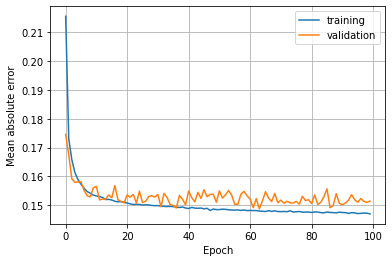

In [80]:
plot_loss(history)

#### 2nd test : 4 hidden layer model using Dropout layer and L2 regularizer

* An important hyperparameter in neural networks is the *learning rate*.

* This determines how large the corrections made to the weights and polarizations at each step of learning will be.

* If the learning rate is large, then the corrections are large, and the network learns quickly.

* On the other hand, it may be "careless": the corrections may be so large that it strays from the optimal values of weights and polarizations.

* If the learning rate is low, then the corrections are smaller, the network learns more conservatively, and it takes longer to train.

* If the SGD optimizer (or others) is used, a variable learning rate can be set.

* In particular, a *learning schedule* will be defined, in which the learning rate will be gradually reduced.

* The idea is that initially the neural network will learn quickly, but as training progresses it will become more attentive.

In [81]:
NUM_EPOCHS = 100
BATCH_SIZE = 64
STEPS_PER_EPOCH = X_train_scaled.shape[0] // BATCH_SIZE

In [82]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.1,
  decay_steps=STEPS_PER_EPOCH * 10,
  decay_rate=1,
  staircase=False)

* In order to avoid wasting time training the network in more seasons than needed, a mechanism for early termination can be used.

* Training will be stopped if no improvement is made in 50 seasons.

In [83]:
early_stop = keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=50)

* One way to combat over-adaptation in neural networks is through *dropout*, which perhaps in Greek could be rendered as "harvesting".

* The [idea behind dropout](https://en.wikipedia.org/wiki/Convolutional_neural_network#Dropout) is that at each step of training, nodes are "dropped" with probability $p$ or retained with probability $1 - p$.

* In effect, nodes with probability $p$ are harvested by the neural network.

* In the next step of training, the nodes that will be discarded again are chosen randomly, so some will be re-entered and some will be dropped.

* Another idea to avoid overfitting is *regularization*.

* In this approach, weights are reduced to zero. 

* The reason is that the fewer weights in the final model, the fewer parameters there are at the end, so the leaner the final model is.

* In particular, if `regularizers.l2(0.001)` is used, as below, each weight will add $0{,}001 \times w^2$ to the network loss.

In [84]:
model_2 = keras.Sequential([
    layers.Dense(32, input_shape=(X_train_scaled.shape[1],),
                 kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dropout(0.5),  
    layers.Dense(16,
                 kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(32,
                 kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(64,
                 kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(128,
                 kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

model_2.compile(loss = 'mean_absolute_error',
                metrics = ['mean_absolute_error'],
              optimizer=tf.keras.optimizers.SGD(lr_schedule))

In [85]:
model_2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 32)                416       
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_31 (Dense)            (None, 16)                528       
                                                                 
 dropout_11 (Dropout)        (None, 16)                0         
                                                                 
 dense_32 (Dense)            (None, 32)                544       
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_33 (Dense)            (None, 64)               

In [86]:
history_2 = model_2.fit(
    X_train_scaled, 
    y_train,
    epochs = NUM_EPOCHS,
    batch_size = BATCH_SIZE,
    validation_split=0.3,
    verbose=2,
    callbacks=[early_stop])

Epoch 1/100
152/152 - 1s - loss: 0.4457 - mean_absolute_error: 0.2681 - val_loss: 0.3495 - val_mean_absolute_error: 0.1801 - 1s/epoch - 8ms/step
Epoch 2/100
152/152 - 0s - loss: 0.3546 - mean_absolute_error: 0.1913 - val_loss: 0.3307 - val_mean_absolute_error: 0.1733 - 293ms/epoch - 2ms/step
Epoch 3/100
152/152 - 0s - loss: 0.3367 - mean_absolute_error: 0.1842 - val_loss: 0.3129 - val_mean_absolute_error: 0.1652 - 287ms/epoch - 2ms/step
Epoch 4/100
152/152 - 0s - loss: 0.3232 - mean_absolute_error: 0.1798 - val_loss: 0.2989 - val_mean_absolute_error: 0.1595 - 297ms/epoch - 2ms/step
Epoch 5/100
152/152 - 0s - loss: 0.3119 - mean_absolute_error: 0.1762 - val_loss: 0.2938 - val_mean_absolute_error: 0.1617 - 308ms/epoch - 2ms/step
Epoch 6/100
152/152 - 0s - loss: 0.3032 - mean_absolute_error: 0.1743 - val_loss: 0.2863 - val_mean_absolute_error: 0.1606 - 386ms/epoch - 3ms/step
Epoch 7/100
152/152 - 0s - loss: 0.2962 - mean_absolute_error: 0.1733 - val_loss: 0.2809 - val_mean_absolute_error:

In [87]:
y_pred = model_2.predict(X_test_scaled)
mean_absolute_error(y_test,y_pred)

0.16295997323998077

In [88]:
def plot_loss(history_2):
    plt.plot(history_2.history['loss'], label='training')
    plt.plot(history_2.history['val_loss'], label='validation')
    plt.xlabel('Epoch')
    plt.ylabel('Mean absolute error')
    plt.legend()
    plt.grid(True)

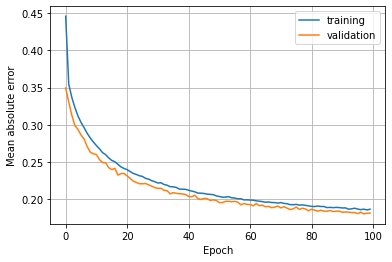

In [89]:
plot_loss(history_2)

#### 3rd test : Model with 4 hidden layers and no anti-overfitting methods

In [90]:
model_3 = keras.Sequential([
        layers.Dense(32, input_shape=(X_train_scaled.shape[1],) , activation='elu'),
        layers.Dense(16 , activation='elu'),
        layers.Dense(32 , activation='elu'),
        layers.Dense(64 , activation='elu'),
        layers.Dense(128 , activation='elu'),
        layers.Dense(1)
    ])

model_3.compile(loss='mean_absolute_error',
                metrics = ['mean_absolute_error'],
              optimizer=tf.keras.optimizers.SGD(0.01))

In [91]:
model_3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 32)                416       
                                                                 
 dense_37 (Dense)            (None, 16)                528       
                                                                 
 dense_38 (Dense)            (None, 32)                544       
                                                                 
 dense_39 (Dense)            (None, 64)                2112      
                                                                 
 dense_40 (Dense)            (None, 128)               8320      
                                                                 
 dense_41 (Dense)            (None, 1)                 129       
                                                                 
Total params: 12,049
Trainable params: 12,049
Non-trai

In [92]:
history_3 = model_3.fit(
    X_train_scaled, 
    y_train,
    epochs=100, 
    validation_split=0.3,
    verbose=2,
    callbacks=[early_stop])

Epoch 1/100
304/304 - 1s - loss: 0.1732 - mean_absolute_error: 0.1732 - val_loss: 0.1543 - val_mean_absolute_error: 0.1543 - 789ms/epoch - 3ms/step
Epoch 2/100
304/304 - 0s - loss: 0.1574 - mean_absolute_error: 0.1574 - val_loss: 0.1552 - val_mean_absolute_error: 0.1552 - 331ms/epoch - 1ms/step
Epoch 3/100
304/304 - 0s - loss: 0.1557 - mean_absolute_error: 0.1557 - val_loss: 0.1553 - val_mean_absolute_error: 0.1553 - 325ms/epoch - 1ms/step
Epoch 4/100
304/304 - 0s - loss: 0.1552 - mean_absolute_error: 0.1552 - val_loss: 0.1608 - val_mean_absolute_error: 0.1608 - 325ms/epoch - 1ms/step
Epoch 5/100
304/304 - 0s - loss: 0.1543 - mean_absolute_error: 0.1543 - val_loss: 0.1527 - val_mean_absolute_error: 0.1527 - 418ms/epoch - 1ms/step
Epoch 6/100
304/304 - 0s - loss: 0.1540 - mean_absolute_error: 0.1540 - val_loss: 0.1562 - val_mean_absolute_error: 0.1562 - 351ms/epoch - 1ms/step
Epoch 7/100
304/304 - 0s - loss: 0.1534 - mean_absolute_error: 0.1534 - val_loss: 0.1550 - val_mean_absolute_err

In [93]:
y_pred = model_3.predict(X_test_scaled)
mean_absolute_error(y_test,y_pred)

0.1561015270254288

In [94]:
def plot_loss(history_3):
    plt.plot(history.history['loss'], label='training')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epoch')
    plt.ylabel('Mean absolute error')
    plt.legend()
    plt.grid(True)

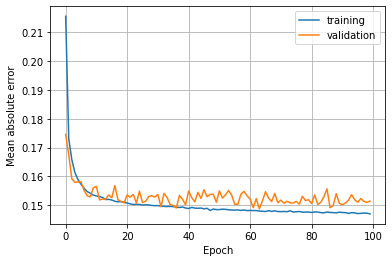

In [95]:
plot_loss(history_3)

### Summary

* The 4 hidden-layer neural network model without anti-overfitting methods finally got the best result among them.

* All the optimizers with `learning_rate = 0.001, 0.01 and 0.1` were tested and the best results were obtained by `Adam`, `Adagrad` and `SGD`. `SGD` was chosen to be presented.

* In these tests , the models were not very complex and so it did not take much time to train them.

* On the contrary, the random forests and the AdaBoost method took a long time in order to optimize them with the Random Search method.

* It is well known that neural networks are a very powerful tool, as it was shown because in a very short time they achieved the results of the other machine learning methods.

* The Boost method (AdaBoost) , finally produced the best result out of all the methods used.

* The results are shown in the table below.

<table>
    <tr>
        <th colspan="6"> Non-Neural Networks</th>
    </tr>
    <tr>
        <th></th>
        <th>Decision Tree</th>
        <th>KNeighborsRegressor</th>
        <th>SVR</th>
        <th>Random Forest</th>
        <th>AdaBoost</th> 
    </tr>
    <tr>
        <th>Mean Absolute Error</th>
        <td>0.1624</td>
        <td>0.1675</td>
        <td>0.1924</td>
        <td>0.1377</td>
        <td>0.1293</td>
    </tr>
</table>


<table>
    <tr>
        <th colspan="4"> Neural Networks</th>
    </tr>
    <tr>
        <th></th>
        <th>No hidden layers </th>
        <th>4 hidden layers with Dropout & L2</th>
        <th>4 hidden layers</th>  
    </tr>
    <tr>
        <th>Mean Absolute Error</th>
        <td>0.1578</td>
        <td>0.1629</td>
        <td>0.1561</td>
    </tr>
</table>